In [1]:
import kagglehub # official Kaggle library

path = kagglehub.dataset_download("nikhileswarkomati/suicide-watch")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\isabe\.cache\kagglehub\datasets\nikhileswarkomati\suicide-watch\versions\14


In [2]:
import os # files manipulation system module
import pandas as pd

dataset_folder = path

csv_file = "Suicide_Detection.csv"

csv_path = os.path.join(dataset_folder, csv_file) # puts the file in the path specified folder

print(f"Chemin complet : {csv_path}")

Chemin complet : C:\Users\isabe\.cache\kagglehub\datasets\nikhileswarkomati\suicide-watch\versions\14\Suicide_Detection.csv


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# NLP libraries
import re # regular expressions, drops e-mails, URL or special characters
import string 
import nltk # natural language toolkit, standard Python NLP library
from nltk.corpus import stopwords # drops empty words ("the", "a", "him", etc...) that don't have singnifical impact
from nltk.stem import WordNetLemmatizer # lemmatization to canonize words

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer # transforms words into vectors
from sklearn.linear_model import LogisticRegression # selected classifier model
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# NLTK ressources download
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\isabe\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\isabe\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
# Load dataset in a dataframe
df = pd.read_csv(csv_path)

# Analyses the first lines
print(df.shape)
print(df.head())

(232074, 3)
   Unnamed: 0                                               text        class
0           2  Ex Wife Threatening SuicideRecently I left my ...      suicide
1           3  Am I weird I don't get affected by compliments...  non-suicide
2           4  Finally 2020 is almost over... So I can never ...  non-suicide
3           8          i need helpjust help me im crying so hard      suicide
4           9  I’m so lostHello, my name is Adam (16) and I’v...      suicide


In [5]:
# Descriptive analysis
# Basic info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232074 entries, 0 to 232073
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  232074 non-null  int64 
 1   text        232074 non-null  object
 2   class       232074 non-null  object
dtypes: int64(1), object(2)
memory usage: 5.3+ MB


In [6]:
df= df.drop(df.columns[0], axis = 1)
df.head()
# we drop the Unnamed column that is useless for the project

,text,class
0,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,Am I weird I don't get affected by compliments...,non-suicide
2,Finally 2020 is almost over... So I can never ...,non-suicide
3,i need helpjust help me im crying so hard,suicide
4,"I’m so lostHello, my name is Adam (16) and I’v...",suicide


In [7]:
df.isnull().sum() # looks for empty cells 

text     0
class    0
dtype: int64

In [8]:
df['class'].value_counts()

class
suicide        116037
non-suicide    116037
Name: count, dtype: int64

The classes are perfectly balanced

In [9]:
# Text lenght analysis character-wise
df['text_length'] = df['text'].apply(len)
df['text_length'].describe()

count    232074.000000
mean        689.639736
std        1156.334007
min           3.000000
25%         138.000000
50%         315.000000
75%         801.000000
max       40297.000000
Name: text_length, dtype: float64

In [10]:
df.nunique() # looks for how many different variables there are in each column

text           232074
class               2
text_length      6702
dtype: int64

## preprocessing
we already droped the first column

In [11]:
# cleaning text function
def clean_text(text):
    text = text.lower()
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # links
    text = re.sub(r'<.*?>', '', text)                  # HTML syntax 
    text = re.sub(f"[{re.escape(string.punctuation)}]", '', text)  # ponctuation
    text = text.strip()
    return text

df['clean_text'] = df['text'].apply(clean_text)
df.head()

,text,class,text_length,clean_text
0,Ex Wife Threatening SuicideRecently I left my ...,suicide,715,ex wife threatening suiciderecently i left my ...
1,Am I weird I don't get affected by compliments...,non-suicide,138,am i weird i dont get affected by compliments ...
2,Finally 2020 is almost over... So I can never ...,non-suicide,129,finally 2020 is almost over so i can never hea...
3,i need helpjust help me im crying so hard,suicide,41,i need helpjust help me im crying so hard
4,"I’m so lostHello, my name is Adam (16) and I’v...",suicide,2426,i’m so losthello my name is adam 16 and i’ve b...


We use apply instead of map only because map is usually used to **substitute** a value into an other. Apply is more ofet used to apply whole algorithms or function. We used it here because the clean_text function is quite complex and **transforms** instead of substituying

In [12]:
stop_words = set(stopwords.words('english')) 
# we focus on stopwords such as "the, is, a, an, in, on..."
# we use set becase it's much faster than a list

lemmatizer = WordNetLemmatizer()
# canonizes word ex : fastest -> fast
# we don't use stemming here because it just cuts the end of the word, lemmatization acounts the grammar too, ex: feet -> foot

def preprocess_text(text):
    words = text.split() # turns sentences into list of words
    words = [lemmatizer.lemmatize(w) for w in words if w not in stop_words]
    # we lemmatize each word of the text if it's not a stop word
    return " ".join(words) #reconstruction of the lemmatized sentence

df['preprocessed_text'] = df['clean_text'].apply(preprocess_text)
df.head()

,text,class,text_length,clean_text,preprocessed_text
0,Ex Wife Threatening SuicideRecently I left my ...,suicide,715,ex wife threatening suiciderecently i left my ...,ex wife threatening suiciderecently left wife ...
1,Am I weird I don't get affected by compliments...,non-suicide,138,am i weird i dont get affected by compliments ...,weird dont get affected compliment coming some...
2,Finally 2020 is almost over... So I can never ...,non-suicide,129,finally 2020 is almost over so i can never hea...,finally 2020 almost never hear 2020 bad year e...
3,i need helpjust help me im crying so hard,suicide,41,i need helpjust help me im crying so hard,need helpjust help im cry hard
4,"I’m so lostHello, my name is Adam (16) and I’v...",suicide,2426,i’m so losthello my name is adam 16 and i’ve b...,i’m losthello name adam 16 i’ve struggling yea...


## Formalisation du problème
This is a texte supervised classification problem.
The goal is to define whether a text expresses suicidad thoughts or not.
The target feature is 'class' ('suicidal'/'non-suicidal')
It's a binary classification type problem.
Main metrics : accuracy, f1-score

In [13]:
X = df['preprocessed_text'] # input data
y = df['class'] # predicted class

# train test split with 20% for the test and 80% for the train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y) 
# strtify = y forces the sets to follow the dataset class proportions

## Baseline model


In [14]:
# Vectorization TF-IDF
vectorizer = TfidfVectorizer(max_features = 5000) # we ask the model to only keep the 5000 most important words of the dataset
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

With TF-IDF a word that appears a lot in a cell but not overall in the dataset has a bigget weight than a word that appears globally a lot

In [15]:
# Logistic Regression Model
model = LogisticRegression(max_iter = 200)
model.fit(X_train_tfidf, y_train)

LogisticRegression(max_iter=200)

In [16]:
# Predictions with LR
y_pred = model.predict(X_test_tfidf)

# Model evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.934719379510934

Classification Report:
               precision    recall  f1-score   support

 non-suicide       0.93      0.94      0.94     23208
     suicide       0.94      0.93      0.93     23207

    accuracy                           0.93     46415
   macro avg       0.93      0.93      0.93     46415
weighted avg       0.93      0.93      0.93     46415



We observe that we obtain a really high accuracy wich is a really good thin, it means that our model accurately predict if the message is linked with suicidal thoughts. 

**Precision** : is the model prediction correct ?

**Recall** : Out of all the suicides, how many did the model find ? really important metric since we litterally are trying to save lives, we rather have a false positive than a missed one.

**F1-score** harmonic mean between precision and recall 

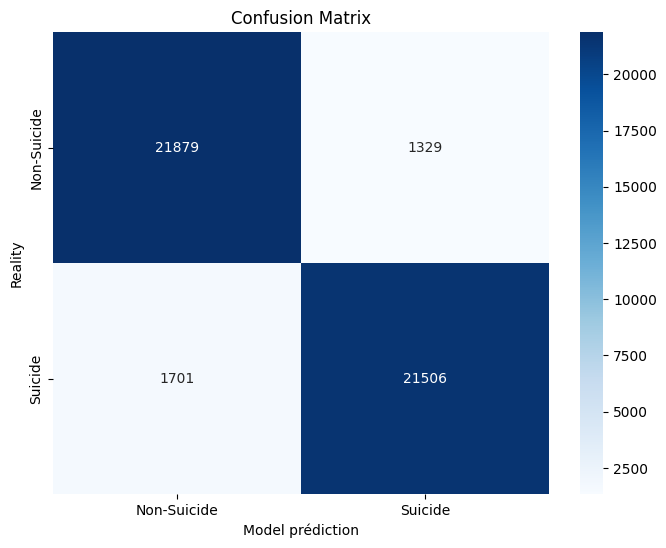

In [17]:
# Compute matrix
cm = confusion_matrix(y_test, y_pred)

# Show the matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Non-Suicide', 'Suicide'], 
            yticklabels=['Non-Suicide', 'Suicide'])
plt.xlabel('Model prédiction')
plt.ylabel('Reality')
plt.title('Confusion Matrix')
plt.show()

The lines are the real values and the columns are the predicted ones, we obtain a proportion of good answers that is quite good.

In [18]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV # automatically test each possible combination (ex: 5000 or 1000 words)
from sklearn.ensemble import BaggingClassifier # combines models for better stability

logreg_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('logreg', LogisticRegression(random_state = 42, max_iter = 500))
])


We create a pipeline to automatize the process that we previously implemented manually. 
With a pipeline, the input is the uncleaned text and the output is the prediciton. It helps a lot with data leakage, ensuring that TF-IDF don't learn from test data by error in a context such as crossed validation. It isalates each step perfectly.

In [19]:
param_grid_logreg = {
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'tfidf__max_features': [5000, 10000],
    
    'logreg__C': [0.1, 1, 10], 
} #list of options given to de computer

print("Lancement du Grid Search pour la Régression Logistique (LogReg)...")
grid_logreg = GridSearchCV(logreg_pipeline, param_grid_logreg, cv=3, scoring='f1_weighted', verbose=1, n_jobs=-1)
grid_logreg.fit(X_train, y_train) 
# logreg_pipeline is the tool we want to optimize, 
# param_grid_logreg are the possible options
# crossed validation with 3 folds
# weighted stabilizes the classes
#logreg_fit starts 12 different trainings (2 ngrams x 2 features x 3c) and 3 crossed validations each


best_logreg = grid_logreg.best_estimator_
y_pred_logreg = best_logreg.predict(X_test)

print("\n--- Meilleurs Résultats LogReg Optimale ---")
print(f"Meilleurs hyperparamètres: {grid_logreg.best_params_}")
print(f"Exactitude (Test): {accuracy_score(y_test, y_pred_logreg):.4f}")
print("Rapport de Classification (LogReg Optimale):")
print(classification_report(y_test, y_pred_logreg))

Lancement du Grid Search pour la Régression Logistique (LogReg)...
Fitting 3 folds for each of 12 candidates, totalling 36 fits

--- Meilleurs Résultats LogReg Optimale ---
Meilleurs hyperparamètres: {'logreg__C': 10, 'tfidf__max_features': 10000, 'tfidf__ngram_range': (1, 1)}
Exactitude (Test): 0.9379
Rapport de Classification (LogReg Optimale):
              precision    recall  f1-score   support

 non-suicide       0.93      0.94      0.94     23208
     suicide       0.94      0.93      0.94     23207

    accuracy                           0.94     46415
   macro avg       0.94      0.94      0.94     46415
weighted avg       0.94      0.94      0.94     46415



In [20]:
# Ensemble learning
best_logreg_params = {k.replace('logreg__', ''): v for k, v in grid_logreg.best_params_.items() if k.startswith('logreg__')}
best_logreg_model = LogisticRegression(random_state=42, max_iter=500, **best_logreg_params)

bagging_model = BaggingClassifier(
    estimator=best_logreg_model,
    n_estimators=50,      
    max_samples=0.8, # each clone only sees 80% of the training dataset
    bootstrap=True, # independent tests
    random_state=42,
    n_jobs=-1
)
# Mean of 50 "votes" for the best prediction

print("\nLancement de l'entraînement du Bagging Classifier...")
bagging_model.fit(X_train_tfidf, y_train)

y_pred_bagging = bagging_model.predict(X_test_tfidf)

print("\n--- Résultats Bagging (LogReg) ---")
print(f"Exactitude (Test): {accuracy_score(y_test, y_pred_bagging):.4f}")
print("Rapport de Classification (Bagging):")
print(classification_report(y_test, y_pred_bagging))


Lancement de l'entraînement du Bagging Classifier...

--- Résultats Bagging (LogReg) ---
Exactitude (Test): 0.9352
Rapport de Classification (Bagging):
              precision    recall  f1-score   support

 non-suicide       0.93      0.94      0.94     23208
     suicide       0.94      0.93      0.93     23207

    accuracy                           0.94     46415
   macro avg       0.94      0.94      0.94     46415
weighted avg       0.94      0.94      0.94     46415



C:\Users\isabe\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


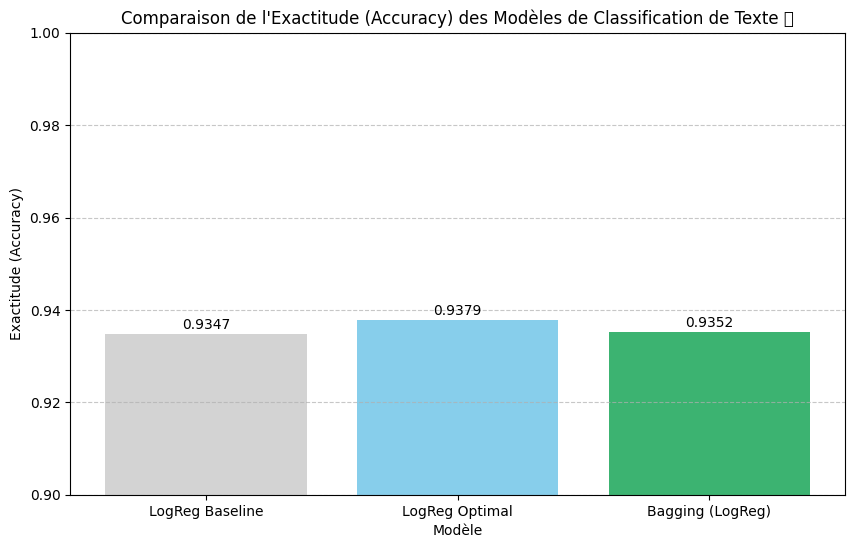

In [21]:
# 1. Base model metrics computing
baseline_accuracy = accuracy_score(y_test, model.predict(X_test_tfidf)) 
logreg_opt_accuracy = accuracy_score(y_test, y_pred_logreg)
bagging_accuracy = accuracy_score(y_test, y_pred_bagging)

accuracy_results = {
    "LogReg Baseline": baseline_accuracy,
    "LogReg Optimal": logreg_opt_accuracy,
    "Bagging (LogReg)": bagging_accuracy
}

# 2. Bar chart creation
import matplotlib.pyplot as plt

model_names = list(accuracy_results.keys())
accuracies = list(accuracy_results.values())

plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, accuracies, color=['lightgray', 'skyblue', 'mediumseagreen'])

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.0005, f'{yval:.4f}', ha='center', va='bottom')

plt.ylim(0.9, 1.0) # focus on high performance 
plt.title('Comparaison de l\'Exactitude (Accuracy) des Modèles de Classification de Texte 📈')
plt.xlabel('Modèle')
plt.ylabel('Exactitude (Accuracy)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [22]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

# 1. Naïve Bayes
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)
y_pred_nb = nb_model.predict(X_test_tfidf)
print("Naïve Bayes Accuracy:", accuracy_score(y_test, y_pred_nb))

# 2. Linear SVM (Support Vector Machine)
svc_model = LinearSVC(random_state=42, dual='auto') # dual='auto' for better use of lot of smaples
svc_model.fit(X_train_tfidf, y_train)
y_pred_svc = svc_model.predict(X_test_tfidf)
print("Linear SVM Accuracy:", accuracy_score(y_test, y_pred_svc))

# 3. Random Forest 
rf_model = RandomForestClassifier(n_estimators=50, max_depth=20, random_state=42, n_jobs=-1)
rf_model.fit(X_train_tfidf, y_train)
y_pred_rf = rf_model.predict(X_test_tfidf)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))

Naïve Bayes Accuracy: 0.90248841969191
Linear SVM Accuracy: 0.935064095658731
Random Forest Accuracy: 0.860088333512873


In [23]:
def check_overfitting(model, X_train, y_train, X_test, y_test, model_name):
    train_acc = model.score(X_train, y_train)
    test_acc = model.score(X_test, y_test)
    print(f"--- {model_name} ---")
    print(f"Train Accuracy: {train_acc:.4f}")
    print(f"Test Accuracy : {test_acc:.4f}")
    print(f"Gap           : {train_acc - test_acc:.4f}")
    if train_acc - test_acc > 0.05:
        print("ALERT: Probable Overfitting")
    print("\n")

# We verify each model
check_overfitting(best_logreg, X_train, y_train, X_test, y_test, "Logistic Regression (Tuned)")
check_overfitting(nb_model, X_train_tfidf, y_train, X_test_tfidf, y_test, "Naïve Bayes")
check_overfitting(svc_model, X_train_tfidf, y_train, X_test_tfidf, y_test, "Linear SVM")
check_overfitting(rf_model, X_train_tfidf, y_train, X_test_tfidf, y_test, "Random Forest")

--- Logistic Regression (Tuned) ---
Train Accuracy: 0.9489
Test Accuracy : 0.9379
Gap           : 0.0111


--- Naïve Bayes ---
Train Accuracy: 0.9047
Test Accuracy : 0.9025
Gap           : 0.0022


--- Linear SVM ---
Train Accuracy: 0.9428
Test Accuracy : 0.9351
Gap           : 0.0078


--- Random Forest ---
Train Accuracy: 0.8835
Test Accuracy : 0.8601
Gap           : 0.0234




                 Model  Accuracy
0  Logistic Regression  0.937865
2           Linear SVM  0.935064
1          Naïve Bayes  0.902488
3        Random Forest  0.860088


C:\Users\isabe\AppData\Local\Temp\ipykernel_12980\3551215089.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Accuracy', y='Model', data=results_df, palette='viridis')


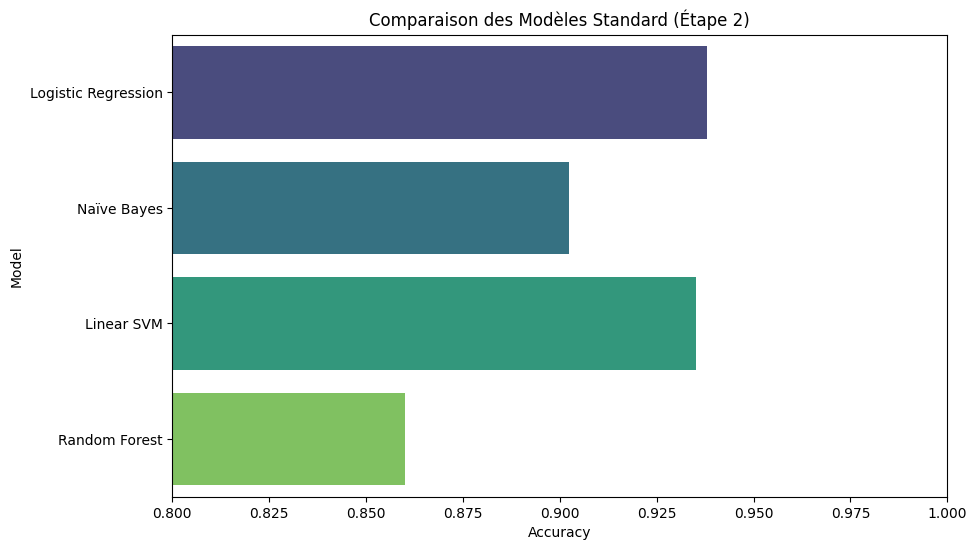

In [24]:
results_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'Naïve Bayes', 'Linear SVM', 'Random Forest'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_logreg),
        accuracy_score(y_test, y_pred_nb),
        accuracy_score(y_test, y_pred_svc),
        accuracy_score(y_test, y_pred_rf)
    ]
})

print(results_df.sort_values(by='Accuracy', ascending=False))

# final visualization
plt.figure(figsize=(10, 6))
sns.barplot(x='Accuracy', y='Model', data=results_df, palette='viridis')
plt.title('Comparaison des Modèles Standard (Étape 2)')
plt.xlim(0.8, 1.0) # Zoomer pour voir les différences
plt.show()